In [ ]:
!pip install --upgrade --force-reinstall pandas


  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstal

In [ ]:
import pandas as pd
import os
import zipfile
from google.colab import files

# 1. zip 파일 업로드 (already done)

# 2. 압축 해제 (already done)
# Let's assume the zip file created a single 'dataset' folder.
# The following code correctly handles the case where the images are one level deeper.

# 3. CSV 생성을 위한 경로 탐색
# Check if the images are in 'dataset' or 'dataset/dataset'
BASE_DIR = "dataset"
DATASET_DIR = BASE_DIR
if "dataset" in os.listdir(BASE_DIR) and os.path.isdir(os.path.join(BASE_DIR, "dataset")):
    DATASET_DIR = os.path.join(BASE_DIR, "dataset")

image_paths, object_types, material_types = [], [], []

# 경로가 존재하는지 확인
if not os.path.exists(DATASET_DIR):
    print(f"❌ '{DATASET_DIR}' 폴더를 찾을 수 없습니다. 압축 해제가 실패했거나 경로가 올바르지 않습니다.")
    exit()

print(f"✅ 데이터셋 경로: {DATASET_DIR}")

for obj in os.listdir(DATASET_DIR):
    obj_path = os.path.join(DATASET_DIR, obj)

    if not os.path.isdir(obj_path):
        continue

    if obj == 'cup':
        for material in os.listdir(obj_path):
            mat_path = os.path.join(obj_path, material)
            if os.path.isdir(mat_path):
                for fname in os.listdir(mat_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(mat_path, fname))
                        object_types.append(obj)
                        material_types.append(material)

    elif obj == 'straw':
        for sub in os.listdir(obj_path):
            sub_path = os.path.join(obj_path, sub)
            if os.path.isdir(sub_path):
                for fname in os.listdir(sub_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(sub_path, fname))
                        object_types.append(obj)
                        material_types.append("plastic")
            elif sub.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(obj_path, sub))
                object_types.append(obj)
                material_types.append("plastic")

    elif obj == 'cupholder':
        for fname in os.listdir(obj_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(obj_path, fname))
                object_types.append(obj)
                material_types.append("paper")

    elif obj == 'lid':
        for fname in os.listdir(obj_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(obj_path, fname))
                object_types.append(obj)
                material_types.append("plastic")

    elif obj == 'none':
        for fname in os.listdir(obj_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(obj_path, fname))
                object_types.append("none")
                material_types.append("none")

# 4. CSV 생성 및 저장
if image_paths:
    df = pd.DataFrame({
        "image_path": image_paths,
        "object_type": object_types,
        "material_type": material_types
    })
    df.to_csv("labels.csv", index=False)
    print(f"✅ labels.csv 생성 완료! 총 {len(df)}개의 데이터가 포함되었습니다.")

    # 5. 다운로드
    files.download("labels.csv")
    print("✅ labels.csv 다운로드 완료!")
else:
    print("⚠️ 이미지 파일이 발견되지 않았습니다. CSV 파일을 생성하지 않습니다.")

✅ 데이터셋 경로: dataset/dataset
✅ labels.csv 생성 완료! 총 331개의 데이터가 포함되었습니다.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ labels.csv 다운로드 완료!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import numpy as np
from pathlib import Path

df = pd.read_csv("/content/labels.csv")

# ✅ 'none' 클래스까지 포함
object_type_map = {'cup': 0, 'cupholder': 1, 'lid': 2, 'straw': 3, 'none': 4}
material_type_map = {'paper': 0, 'plastic': 1, 'none': 2}

# ✅ 매핑 적용
df['object_label'] = df['object_type'].map(object_type_map)
df['material_label'] = df['material_type'].map(material_type_map)

print(df.head())


                            image_path object_type material_type  \
0  dataset/dataset/straw/straw_080.jpg       straw       plastic   
1  dataset/dataset/straw/straw_034.jpg       straw       plastic   
2  dataset/dataset/straw/straw_009.jpg       straw       plastic   
3  dataset/dataset/straw/straw_002.jpg       straw       plastic   
4  dataset/dataset/straw/straw_008.jpg       straw       plastic   

   object_label  material_label  
0             3               1  
1             3               1  
2             3               1  
3             3               1  
4             3               1  


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[['object_label', 'material_label']]
)


tf.data.Dataset 만들기

In [ ]:
import tensorflow as tf

IMG_SIZE = (180, 180)
BATCH_SIZE = 32

def preprocess(image_path, object_label, material_label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, {'object_output': object_label, 'material_output': material_label}

def create_dataset(dataframe, shuffle=True):
    paths = dataframe['image_path'].values
    obj_labels = dataframe['object_label'].values
    mat_labels = dataframe['material_label'].values

    dataset = tf.data.Dataset.from_tensor_slices((paths, obj_labels, mat_labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df, shuffle=False)


데이터 증강 레이어 (훈련용에만 적용)

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment(image, labels):
    return data_augmentation(image, training=True), labels

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


모델 구성 (MobileNetV2 + Multi-output)

In [ ]:
from tensorflow.keras import models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(180, 180, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

# 수정된 부분: object_output 노드 수 5로 변경
object_output = layers.Dense(5, activation='softmax', name='object_output')(x)
# 수정된 부분: material_output 노드 수 3으로 변경
material_output = layers.Dense(3, activation='softmax', name='material_output')(x)

model = models.Model(inputs=inputs, outputs={'object_output': object_output, 'material_output': material_output})


/tmp/ipython-input-417377871.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


컴파일 & 학습

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'object_output': 'sparse_categorical_crossentropy',
        'material_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'object_output': 'accuracy',
        'material_output': 'accuracy'
    }
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 1.6114 - material_output_accuracy: 0.6845 - material_output_loss: 0.7056 - object_output_accuracy: 0.6725 - object_output_loss: 0.8901 - val_loss: 0.0879 - val_material_output_accuracy: 0.9851 - val_material_output_loss: 0.0308 - val_object_output_accuracy: 1.0000 - val_object_output_loss: 0.0461
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0742 - material_output_accuracy: 0.9933 - material_output_loss: 0.0299 - object_output_accuracy: 0.9892 - object_output_loss: 0.0434 - val_loss: 0.0142 - val_material_output_accuracy: 1.0000 - val_material_output_loss: 0.0042 - val_object_output_accuracy: 1.0000 - val_object_output_loss: 0.0076
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0145 - material_output_accuracy: 1.0000 - material_output_loss: 0.0071 - object_output_accuracy: 1.0000 - object_output_loss: 0.0074 - val_loss: 0.0045 - val_material_output_accuracy: 1.0000 - val_material_output_loss: 0.0012 - val_ob

In [ ]:
model.save("/content/multilabel_model.keras")
print("모델 저장 완료!")


모델 저장 완료!


In [ ]:
# 수정된 부분: none 클래스 추가
OBJECT_CLASS_NAMES = ['cup', 'cupholder', 'lid', 'straw', 'none']
# 수정된 부분: none 클래스 추가
MATERIAL_CLASS_NAMES = ['paper', 'plastic', 'none']

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from pathlib import Path

def predict_image(img_path, threshold=0.6):
    if not Path(img_path).exists():
        print(f"❌ 파일을 찾을 수 없습니다: {img_path}")
        return

    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array / 255.0, axis=0)

    preds = model.predict(img_array, verbose=0)

    object_probs = preds['object_output'][0]
    material_probs = preds['material_output'][0]

    object_label = np.argmax(object_probs)
    material_label = np.argmax(material_probs)

    # 수정된 부분: none 클래스 처리 로직
    if object_probs[object_label] < threshold and object_label != 4:
        print(f"물체 예측: 예측 불가 (Conf: {object_probs[object_label]:.2f})")
    else:
        print(f"물체 예측: {OBJECT_CLASS_NAMES[object_label]} ({object_probs[object_label]*100:.2f}%)")

    # 수정된 부분: none 클래스 처리 로직
    if material_probs[material_label] < threshold and material_label != 2:
        print(f"재질 예측: 예측 불가 (Conf: {material_probs[material_label]:.2f})")
    else:
        print(f"재질 예측: {MATERIAL_CLASS_NAMES[material_label]} ({material_probs[material_label]*100:.2f}%)")




In [ ]:
predict_image("/content/dataset/dataset/cup/paper/cup_paper_001.jpg")
predict_image("/content/dataset/dataset/lid/lid_001.jpg")


물체 예측: cup (99.97%)
재질 예측: paper (99.96%)
물체 예측: lid (100.00%)
재질 예측: plastic (100.00%)


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_and_show(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array / 255.0, axis=0)

    preds = model.predict(img_array)

    object_probs = preds['object_output'][0]
    material_probs = preds['material_output'][0]

    object_label = np.argmax(object_probs)
    material_label = np.argmax(material_probs)

    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.title(f"🧠 {OBJECT_CLASS_NAMES[object_label]} ({object_probs[object_label]*100:.1f}%)\n🧪 {MATERIAL_CLASS_NAMES[material_label]} ({material_probs[material_label]*100:.1f}%)")
    plt.show()


In [ ]:
predict_image("/content/dataset/dataset/cup/paper/cup_paper_013.jpg")

물체 예측: cup (99.99%)
재질 예측: paper (99.89%)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# 예: object_output 예측
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    obj_label = labels['object_output'].numpy()
    pred_label = np.argmax(pred['object_output'][0])
    y_true.append(obj_label)
    y_pred.append(pred_label)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=OBJECT_CLASS_NAMES))


[[14  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 13]]
              precision    recall  f1-score   support

         cup       1.00      1.00      1.00        14
   cupholder       1.00      1.00      1.00        12
         lid       1.00      1.00      1.00        12
       straw       1.00      1.00      1.00        16
        none       1.00      1.00      1.00        13

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



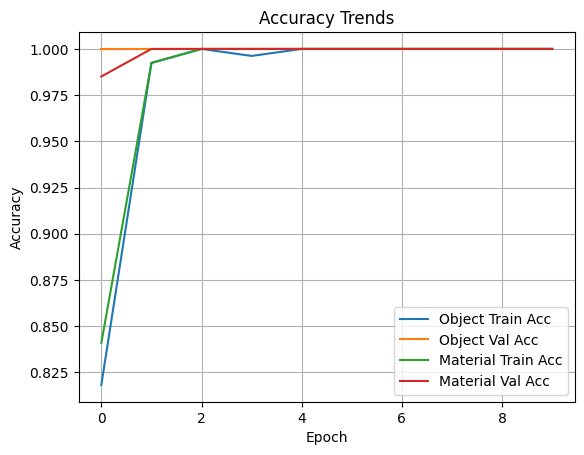

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['object_output_accuracy'], label='Object Train Acc')
plt.plot(history.history['val_object_output_accuracy'], label='Object Val Acc')
plt.plot(history.history['material_output_accuracy'], label='Material Train Acc')
plt.plot(history.history['val_material_output_accuracy'], label='Material Val Acc')
plt.title('Accuracy Trends')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
